In [ ]:
import networkx as nx
import pandas as pd
import matplotlib.pyplot as plt
import plotly.express as px
import random

from auxiliaries import *

random.seed(34)

In [ ]:
# types of routes
types_berlin = {
    0: "tram",
    1: "subway",
    2: "rail",
    3: "bus",
    4: "ferry",
    5: "walking",
}

## Performing experiments on Berlin network

### Instructions / how the code works:

Step1
- reads in both networks (combined and walking)
- Then converts the walking dataframe to comform with the combined dataframe
- Then creates a new dataframe with the combined and walking dataframes

Step2
- Converts the full network to a graph
- Adds the positions of the node (in x and y coordinates) to the graph

Step3 (fixing the walking graph)
- Since the walking map is not connected, seperately convert only the walking dataframe to a graph
- Then the function "make_walking_connected", takes both G and G_walk, and makes the "walk" part of G connected by adding the edges to G that are necessary to make G_walk connected. It also adds some edges to G_walk because there are stops (nodes) in G that are not in G_walk for some reason

Step4 (experiments)
- The function "percolation_experiments" performs the experiments (see source code in [auxiliaries.py](auxiliaries.py))
- By default the method is "random", but it can also be "degree", "betweenness", "closeness" or "eigenvector". If a method is specified it will then remove the edges in order of the method, otherwise it will remove random edges.
It takes parameters for:
  - G (the graph)
  - p_min (the minimum percolation degree)
  - p_max (the maximum percolation degree)
  - steps (the step size in varying the percolation degree)
  - n_tests (the number of different samples of nodes to test with)
  - n_percolations (the number of different percolations to perform) NOTE: only relevant for random percolation, with the other methods the percolation will be the same every time. If you are using a specific method, just set this to 1.
  - method (the method to use for percolation, default is random)
  - verbose (if you want to see the progress, since the function is quite slow. Default is False)
- The function returns a dataframe with the results of the experiments, and the results can be plotted with the plotting functions at the end of the notebook


In [313]:
# STEP 1
# read in public transport network of berlin and walking network
berlin, berlin_nodes = read_in_network("berlin", "combined")
berlin_walking, nodes_t = read_in_network("berlin", "walk")

# adapt berlin_walking dataframe to match berlin dataframe
berlin_walking = berlin_walking.rename(columns={"d_walk": "duration_avg"})
berlin_walking["duration"] = berlin_walking["duration_avg"].apply(distance_to_duration)
berlin_walking["n_vehicles"] = 0
berlin_walking["route_I_counts"] = 0
berlin_walking["route_type"] = 5

# add berlin_walking to berlin
berlin_full = pd.concat([berlin, berlin_walking], ignore_index=True)

In [346]:
# STEP 2
# convert to graph
G = convert_to_graph(berlin_full)
pos = add_positions(G, berlin_nodes)

# STEP 3
# convert walking network to seperate graph
G_walk = convert_to_graph(berlin_walking)

# make G connected by adding walking edges
make_walking_connected(G, G_walk)

#### Perform percolation experiment

In [323]:
# STEP 4
results = percolation_experiments(G, 0, 1, 20, 1, 5, verbose=True)

In [348]:
results_betweenness = percolation_experiments(G, 0, 1, 20, 1, 1, method="degree", verbose=True)

Getting nodes...

Starting experiments...

p: 0.0, test: 0, time: 2108.4966390076925, perc: 0
p: 0.05263157894736842, test: 0, time: 2970.2631260891626, perc: 0
p: 0.10526315789473684, test: 0, time: 4085.245158620336, perc: 0
p: 0.15789473684210525, test: 0, time: 4978.751233086104, perc: 0
p: 0.21052631578947367, test: 0, time: 5838.154979201204, perc: 0
p: 0.2631578947368421, test: 0, time: 6910.737124520632, perc: 0
p: 0.3157894736842105, test: 0, time: 7832.503344743118, perc: 0
p: 0.3684210526315789, test: 0, time: 8848.28641918499, perc: 0
p: 0.42105263157894735, test: 0, time: 10154.674343940836, perc: 0
p: 0.47368421052631576, test: 0, time: 12492.724527562117, perc: 0
p: 0.5263157894736842, test: 0, time: 14661.223788140782, perc: 0
p: 0.5789473684210527, test: 0, time: 16188.014766350403, perc: 0
p: 0.631578947368421, test: 0, time: 19685.897795296463, perc: 0
p: 0.6842105263157894, test: 0, time: 23122.826751886412, perc: 0
p: 0.7368421052631579, test: 0, time: 25241.275480

In [349]:
# dump results to pickle file
import pickle

results.to_pickle("results/results_random.pkl")
results_betweenness.to_pickle("results/results_degree.pkl")

#### Plot results

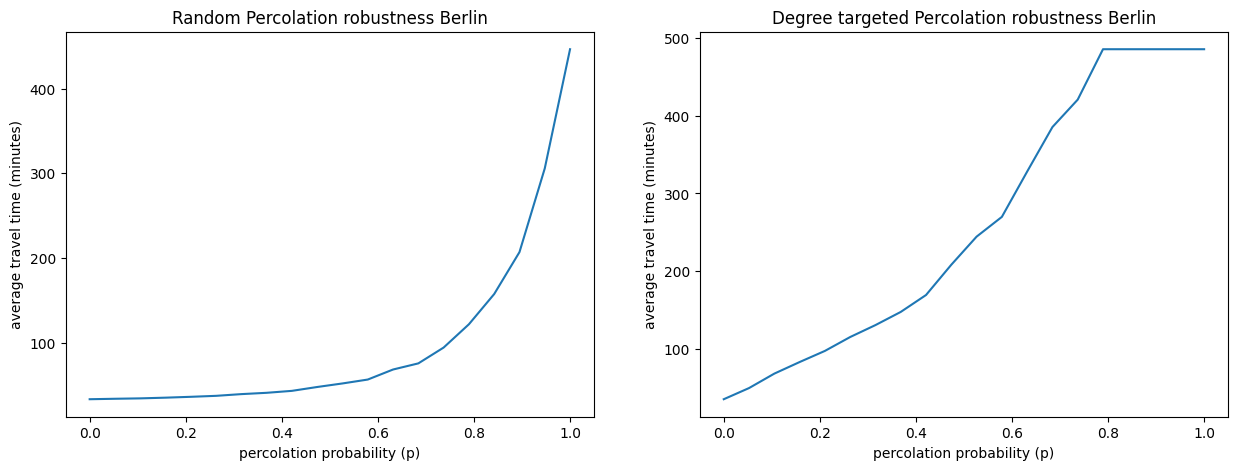

In [353]:
# plot two plots next to each other
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
# plot first plot
x = results.groupby("p").mean().reset_index()["p"]
# divide y by 60 to get minutes
y = results.groupby("p").mean().reset_index()["result"]/60
# set x and y label
ax1.set_xlabel("percolation probability (p)")
ax1.set_ylabel("average travel time (minutes)")
ax1.set_title("Random Percolation robustness Berlin")
ax1.plot(x, y)

# plot second plot
x = results_betweenness.groupby("p").mean().reset_index()["p"]
# divide y by 60 to get minutes
y = results_betweenness.groupby("p").mean().reset_index()["result"]/60
# set x and y label
ax2.set_xlabel("percolation probability (p)")
ax2.set_ylabel("average travel time (minutes)")
ax2.set_title("Degree targeted Percolation robustness Berlin")
ax2.plot(x, y)


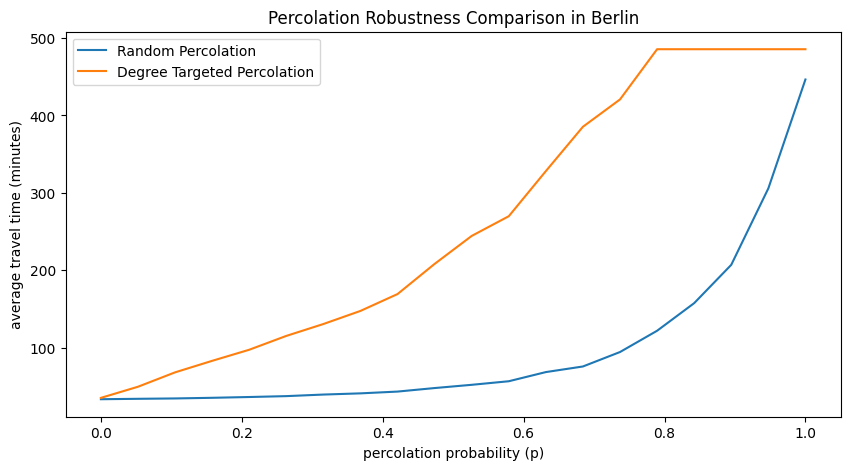

In [355]:
# plot both lines on the same graph
fig, ax = plt.subplots(figsize=(10, 5))

# plot first line
x1 = results.groupby("p").mean().reset_index()["p"]
y1 = results.groupby("p").mean().reset_index()["result"] / 60
ax.plot(x1, y1, label="Random Percolation")

# plot second line
x2 = results_betweenness.groupby("p").mean().reset_index()["p"]
y2 = results_betweenness.groupby("p").mean().reset_index()["result"] / 60
ax.plot(x2, y2, label="Degree Targeted Percolation")

# set x and y labels
ax.set_xlabel("percolation probability (p)")
ax.set_ylabel("average travel time (minutes)")

# set title
ax.set_title("Percolation Robustness Comparison in Berlin")

# add legend
ax.legend()

# display the plot
plt.show()